In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

In [221]:
k = 25

df = (
    pd.read_feather('../data/interim/order_dataset_to_forecastability')
    .assign(sale_date = lambda x: pd.to_datetime(x.sale_date))
)

most_sold = (
    df
    .groupby(['seller_id','sku_id'])
    .qty
    .count()
    .reset_index()
    .query("qty > @k")
    .sku_id
    .values
)

In [236]:
df[df.sku_id.isin(most_sold)]

,sale_date,seller_id,sku_id,qty
4,2016-10-04,624f4ece8da4aafb77699233d480f8ef,817e1c2d22418c36386406ccacfa53e8,1
60,2016-10-06,620c87c171fb2a6dd6e8bb4dec959fc6,473795a355d29305c3ea6b156833adf5,3
177,2016-10-08,cab85505710c7cb9b720bceb52b01cee,9fe172fa8e662ca8572cf12abf8bce23,1
218,2016-10-10,aaed1309374718fdd995ee4c58c9dfcd,a8fe47ad6f852f93cc92c7b408687de3,1
245,2016-10-11,620c87c171fb2a6dd6e8bb4dec959fc6,473795a355d29305c3ea6b156833adf5,1
...,...,...,...,...
92510,2018-08-28,1f50f920176fa81dab994f9023523100,368c6c730842d78016ad823897a372db,1
92526,2018-08-28,6560211a19b47992c3666cc44a7e94c0,c3ba4e8d3cb30049213b682e751e9d00,2
92531,2018-08-28,7040e82f899a04d1b434b795a43b4617,a59fb60fddcc72a9878b7ed5cb69d8e4,1
92553,2018-08-28,da8622b14eb17ae2831f4ac5b9dab84a,e0cf79767c5b016251fe139915c59a26,1


In [210]:
%%time

ts = TimeSeries.from_group_dataframe(df, 
                                     group_cols=['seller_id','sku_id'], 
                                     time_col='sale_date', fill_missing_dates=True,
                                     freq='D', fillna_value=0)

CPU times: user 1.47 s, sys: 204 ms, total: 1.68 s
Wall time: 4.14 s


In [211]:
def find_adi(ts_arr):

    n_periods = len(ts_arr)
    demand_buckets = np.count_nonzero(ts_arr)
    adi = n_periods/demand_buckets
    
    return adi

def find_cv(ts_arr, non_zero=True):
    
    idx_non_zero = ts_arr.nonzero()[0]
    arr_non_zero = ts_arr[idx_non_zero]

    return arr_non_zero.std() / arr_non_zero.mean()

In [212]:
df[(df.seller_id == '0b90b6df587eb83608a64ea8b390cf07')&(df.sku_id == '3f14d740544f37ece8a9e7bc8349797e')]

,sale_date,seller_id,sku_id,qty
54947,2018-03-01,0b90b6df587eb83608a64ea8b390cf07,3f14d740544f37ece8a9e7bc8349797e,1


In [207]:
ts[17]

<TimeSeries (DataArray) (sale_date: 1, component: 1, sample: 1)>
array([[[1.]]])
Coordinates:
  * sale_date  (sale_date) datetime64[ns] 2018-03-01
  * component  (component) object 'qty'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates                         seller_id  ...
    hierarchy:          None

In [206]:
for arr in ts[:100]:
    print((arr.static_covariates['sku_id']['qty'], 
           find_adi(arr.values().squeeze()), 
           find_cv(arr.values().squeeze())**2))

('08574b074924071f4e201e151b152b4e', 4.666666666666667, 0.32793388429752074)
('e251ebd2858be1aa7d9b2087a6992580', 6.90625, 0.40516070620190137)
('363218ba55c610b750224f90bdd34be1', 17.3, 0.07438016528925619)
('0d85c435fd60b277ffb9e9b0f88f927a', 1.0, 0.1111111111111111)
('36f60d45225e60c7da4558b070ce4b60', 2.857142857142857, 0.26388888888888895)
('3f14d740544f37ece8a9e7bc8349797e', 3.25, 0.5510204081632654)
('656e0eca68dcecf6a31b8ececfabe3e8', 5.636363636363637, 0.39039999999999997)
('e53e557d5a159f5aa2c5e995dfdf244b', 8.714285714285714, 0.1234567901234568)
('b8b426747049f2d3d6e00b486d47dedb', 12.368421052631579, 0.07709750566893421)
('78efe838c04bbc568be034082200ac20', 3.345679012345679, 0.19900009802960497)
('595fac2a385ac33a80bd5114aec74eb8', 9.266666666666667, 0.08996539792387542)
('fbc1488c1a1e72ba175f53ab29a248e8', 27.428571428571427, 0.09375000000000001)
('11dcc970f7a5581e1bf777b6da3f7096', 14.384615384615385, 0.16796875000000008)
('19c91ef95d509ea33eda93495c4d3481', 2.8356164383

TypeError: len() of unsized object

In [90]:
t = ts[4].values().squeeze()
t.

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [72]:
find_adi(arr),find_cv(arr)

(4.666666666666667, 0.57265511810995)

In [59]:
arr = ts[1].values().squeeze()

arr[arr.nonzero()[0]].std() / arr[arr.nonzero()[0]].mean()

0.57265511810995

In [27]:
from darts.metrics import coefficient_of_variation

In [114]:
ts[1].static_covariates

static_covariates,seller_id,sku_id
component,,
qty,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e


In [90]:
ts[1]

<TimeSeries (DataArray) (sale_date: 364, component: 1, sample: 1)>
array([[[2.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

...

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[1.]]])
Coordinates:
  * sale_date  (sale_date) datetime64[ns] 2017-03-15 2017-03-16 ... 2018-03-13
  * component  (component) object 'qty'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates                         seller_id  ...
    hierarchy:          None

In [91]:
ts[1].static_covariates_values()

array([['001cca7ae9ae17fb1caed9dfb1094831',
        '08574b074924071f4e201e151b152b4e']], dtype=object)

In [92]:
df[(df.seller_id == ts[1].static_covariates_values()[0][0])&(df.sku_id == ts[1].static_covariates_values()[0][1])]

,sale_date,seller_id,sku_id,qty
3724,2017-03-15,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,2
4537,2017-03-25,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
4671,2017-03-27,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,2
5036,2017-03-31,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
5153,2017-04-02,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
...,...,...,...,...
45077,2018-01-15,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
47886,2018-01-27,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
50401,2018-02-08,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1
52763,2018-02-20,001cca7ae9ae17fb1caed9dfb1094831,08574b074924071f4e201e151b152b4e,1


In [93]:
len(ts[1])-14

350

In [94]:
from darts.models import NaiveSeasonal

train, test = (
    ts[1]
    .add_holidays('BRA')
    .add_datetime_attribute('week', cyclic=True)
    .add_datetime_attribute('month', cyclic=True)
).split_before(len(ts[1])-30)


naive_model = NaiveSeasonal(K=7)
naive_model.fit(train)
naive_forecast = naive_model.predict(30)

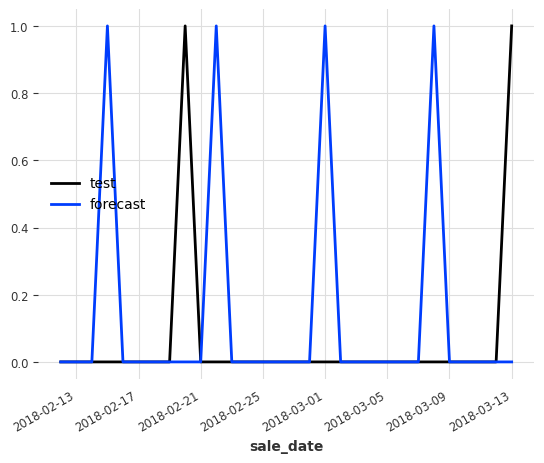

In [95]:
test['qty'].plot(label='test')
naive_forecast['qty'].plot(label='forecast')

In [96]:
from darts.metrics import mape, rmse, mae

In [97]:
rmse(test['qty'], naive_forecast['qty'])
mae(test['qty'], naive_forecast['qty'])

0.2

In [115]:
from darts.models import CatBoostModel

train, test = (
    ts[1]
#     .add_holidays('BRA')
#     .add_datetime_attribute('week', cyclic=True)
#     .add_datetime_attribute('month', cyclic=True)
).split_before(len(ts[1])-30)


model = CatBoostModel(lags=7)
model.fit(train)
model_forecast = model.predict(30)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=7]="001cca7ae9ae17fb1caed9dfb1094831": Cannot convert 'b'001cca7ae9ae17fb1caed9dfb1094831'' to float

In [113]:
ts[1]

<TimeSeries (DataArray) (sale_date: 364, component: 1, sample: 1)>
array([[[2.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

...

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[1.]]])
Coordinates:
  * sale_date  (sale_date) datetime64[ns] 2017-03-15 2017-03-16 ... 2018-03-13
  * component  (component) object 'qty'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates                         seller_id  ...
    hierarchy:          None

In [ ]:
test['qty'].plot(label='test')
naive_forecast['qty'].plot(label='forecast')

In [32]:
df[df.seller_id == '6560211a19b47992c3666cc44a7e94c0'].sale_date.min()

Timestamp('2017-02-17 00:00:00')

In [33]:
df[df.seller_id == '6560211a19b47992c3666cc44a7e94c0'].sale_date.max()

Timestamp('2018-08-29 00:00:00')

In [26]:
def 

df[df.seller_id == '6560211a19b47992c3666cc44a7e94c0']

,sale_date,seller_id,sku_id,qty
2064,2017-02-17,6560211a19b47992c3666cc44a7e94c0,ef79ec374ba852bbced7662285946619,1
2400,2017-02-24,6560211a19b47992c3666cc44a7e94c0,380b4664ba5bb18cc9db78ee6bac3558,1
2401,2017-02-24,6560211a19b47992c3666cc44a7e94c0,aa0816cf69c9faa95e573541be5c0c32,1
2402,2017-02-24,6560211a19b47992c3666cc44a7e94c0,c708ba7c6269161f89ce0683cdd7c432,1
2531,2017-02-27,6560211a19b47992c3666cc44a7e94c0,5d7c23067ed3fc8c6e699b9373d5890b,1
...,...,...,...,...
92464,2018-08-27,6560211a19b47992c3666cc44a7e94c0,c708ba7c6269161f89ce0683cdd7c432,1
92525,2018-08-28,6560211a19b47992c3666cc44a7e94c0,5403528d987ad26e8d7cb25940411987,1
92526,2018-08-28,6560211a19b47992c3666cc44a7e94c0,c3ba4e8d3cb30049213b682e751e9d00,2
92527,2018-08-28,6560211a19b47992c3666cc44a7e94c0,e06f99e79036d681effa3de75989bf22,1


In [25]:
df[df.seller_id == '6560211a19b47992c3666cc44a7e94c0'].pivot_table(index='sku_id',columns='sale_date', values='qty')

sale_date,2017-02-17,2017-02-24,2017-02-27,2017-02-28,2017-03-01,2017-03-03,2017-03-04,2017-03-06,2017-03-07,2017-03-08,...,2018-08-18,2018-08-20,2018-08-21,2018-08-22,2018-08-23,2018-08-24,2018-08-25,2018-08-27,2018-08-28,2018-08-29
sku_id,,,,,,,,,,,,,,,,,,,,,
0067f97995b0c3a86739734dc87ee6b6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01365901d8f2247976a7e5d4c98c52c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02475368dfb38934fe55f574024fe1d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04867a0efbf0779b221235559860b9b8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04af9f3af5c6afc4eece909c25330934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f683f3a5d367251ac1a86404f15615b5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f883c296edea388761ae3de2bc4870f3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f93abb853eee25cbbce73bbc1c10667d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
